In [147]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
from sklearn import tree
import seaborn as sns
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
matplotlib.rcParams["figure.figsize"] = (10,10)

In [148]:
%reload_ext Cython

ModuleNotFoundError: No module named 'Cython'

# Data collection

In [149]:
df = pd.read_csv(r"C:\Users\ekhat\PycharmProjects\pythonProject7777\nigeria_houses_data.csv")
df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


# Boxplots & Data Cleaning

In [150]:
df.drop(['toilets'], axis=1, inplace=True)

In [151]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   parking_space  24326 non-null  float64
 3   title          24326 non-null  object 
 4   town           24326 non-null  object 
 5   state          24326 non-null  object 
 6   price          24326 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.3+ MB


In [152]:
df.isnull().sum() #check for null values

bedrooms         0
bathrooms        0
parking_space    0
title            0
town             0
state            0
price            0
dtype: int64

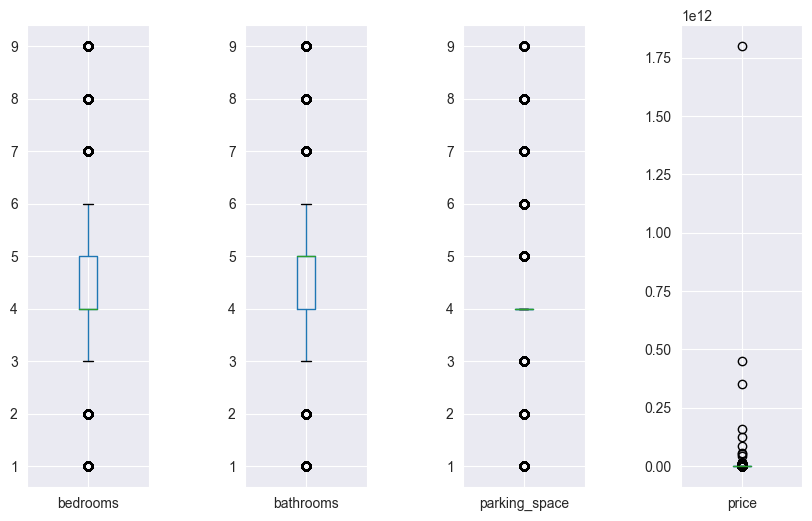

In [153]:
#Boxplot to check for outliers

fig, ax = plt.subplots(1, 4, figsize=(10, 6))

# draw boxplots - for one column in each subplot
df.boxplot('bedrooms', ax=ax[0])
df.boxplot('bathrooms', ax=ax[1])
df.boxplot('parking_space', ax=ax[2])
df.boxplot('price', ax=ax[3])

plt.subplots_adjust(wspace=0.8) 

In [154]:
#removing outliers
def outliers(df,ft):
    q1 = df[ft].quantile(0.25)
    q3 = df[ft].quantile(0.75)
    IQR = q3-q1
    min= q1 - 1.5*IQR
    max= q3 + 1.5*IQR
    
    ls = df.index[(df[ft] < min) | (df[ft] > max)]
    return ls

In [155]:
index_list=[]
for outlier in ['bedrooms','bathrooms','parking_space','price']:
    index_list.extend(outliers(df,outlier))

In [156]:
def remove(df,ls):
    ls=sorted(set(ls))
    df=df.drop(ls)
    return df

In [157]:
df2 = remove(df,index_list)
print('old dataset shape',df.shape)
print()
print('new shape--------',df2.shape)

old dataset shape (24326, 7)

new shape-------- (10989, 7)


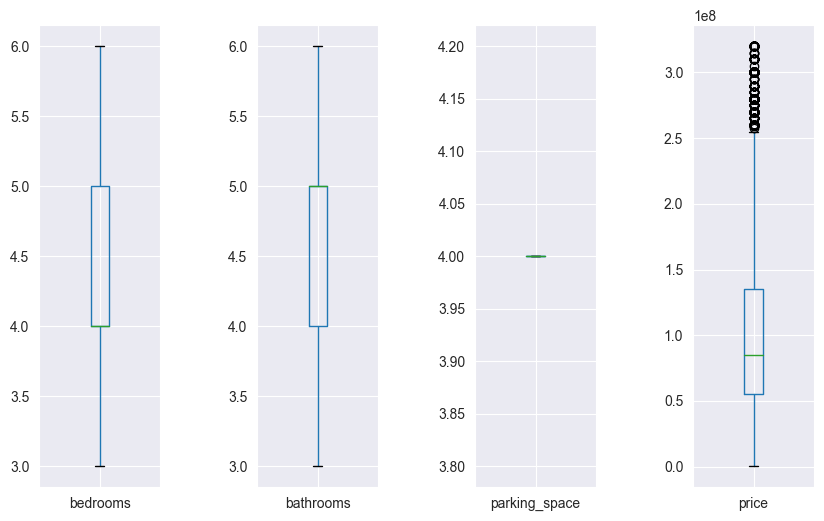

In [158]:
#Boxplot to check for outliers after removal

fig, ax = plt.subplots(1, 4, figsize=(10, 6))

# draw boxplots - for one column in each subplot
df2.boxplot('bedrooms', ax=ax[0])
df2.boxplot('bathrooms', ax=ax[1])
df2.boxplot('parking_space', ax=ax[2])
df2.boxplot('price', ax=ax[3])

#still have outliers for price

plt.subplots_adjust(wspace=0.8) 


# after filtering price still hase outliers

In [159]:
df2.rename(columns = {'title':'house_type'}, inplace = True)
df2.head()


,bedrooms,bathrooms,parking_space,house_type,town,state,price
2,4.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
6,4.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0
10,3.0,4.0,4.0,Terraced Duplexes,Lokogoma District,Abuja,25000000.0
11,6.0,6.0,4.0,Semi Detached Duplex,Oredo,Edo,45000000.0
13,4.0,4.0,4.0,Semi Detached Duplex,Lekki,Lagos,70000000.0


# feature engineering

In [160]:
df2['total_rooms'] = df2['bedrooms'] + df2['bathrooms']
df2.head()

,bedrooms,bathrooms,parking_space,house_type,town,state,price,total_rooms
2,4.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0,9.0
6,4.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0,9.0
10,3.0,4.0,4.0,Terraced Duplexes,Lokogoma District,Abuja,25000000.0,7.0
11,6.0,6.0,4.0,Semi Detached Duplex,Oredo,Edo,45000000.0,12.0
13,4.0,4.0,4.0,Semi Detached Duplex,Lekki,Lagos,70000000.0,8.0


In [161]:
df2['price_per_room'] = df2['price']/df2['total_rooms']


In [162]:
df2['price_per_room'].describe()

count    1.098900e+04
mean     1.134548e+07
std      7.204468e+06
min      4.000000e+04
25%      6.500000e+06
50%      9.375000e+06
75%      1.444444e+07
max      4.333333e+07
Name: price_per_room, dtype: float64

In [163]:
df2.head()

,bedrooms,bathrooms,parking_space,house_type,town,state,price,total_rooms,price_per_room
2,4.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0,9.0,1.333333e+07
6,4.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0,9.0,7.222222e+06
10,3.0,4.0,4.0,Terraced Duplexes,Lokogoma District,Abuja,25000000.0,7.0,3.571429e+06
11,6.0,6.0,4.0,Semi Detached Duplex,Oredo,Edo,45000000.0,12.0,3.750000e+06
13,4.0,4.0,4.0,Semi Detached Duplex,Lekki,Lagos,70000000.0,8.0,8.750000e+06


In [164]:
#function can remove extreme cases based on mean and standard deviation(how it is spread)
def remove_pps_outliers(df): #dataframe
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'): #group by location
        m = np.mean(subdf.price_per_room)
        st = np.std(subdf.price_per_room)
        reduced_df = subdf[(subdf.price_per_room>(m-st)) & (subdf.price_per_room<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index = True)
    return df_out

df3 = remove_pps_outliers(df2)
df3.shape

(8587, 9)

In [165]:
df3.head()

,bedrooms,bathrooms,parking_space,house_type,town,state,price,total_rooms,price_per_room
0,4.0,5.0,4.0,Block of Flats,Aba,Abia,30000000.0,9.0,3.333333e+06
1,5.0,5.0,4.0,Detached Bungalow,Aba,Abia,26000000.0,10.0,2.600000e+06
2,4.0,5.0,4.0,Block of Flats,Aba,Abia,19000000.0,9.0,2.111111e+06
3,3.0,3.0,4.0,Detached Bungalow,Lokogoma District,Abuja,37000000.0,6.0,6.166667e+06
4,4.0,5.0,4.0,Semi Detached Duplex,Gwarinpa,Abuja,75000000.0,9.0,8.333333e+06


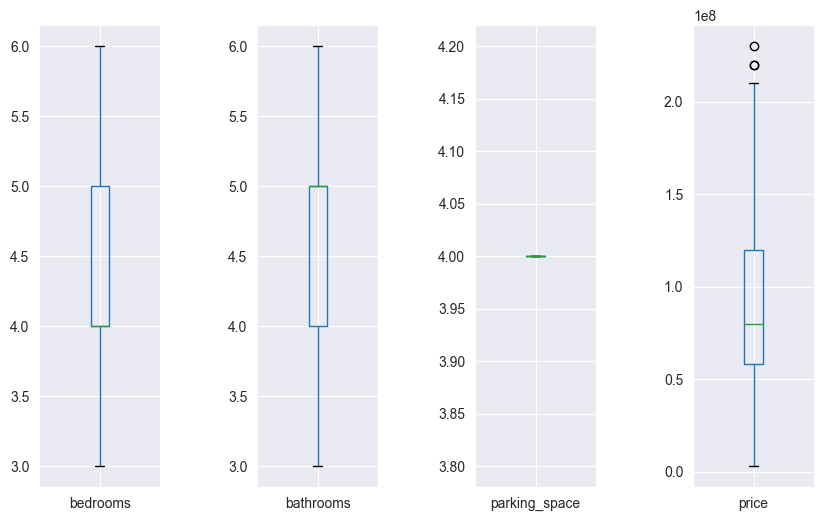

In [166]:
#Boxplot to check for outliers after removal

fig, ax = plt.subplots(1, 4, figsize=(10, 6))

# draw boxplots - for one column in each subplot
df3.boxplot('bedrooms', ax=ax[0])
df3.boxplot('bathrooms', ax=ax[1])
df3.boxplot('parking_space', ax=ax[2])
df3.boxplot('price', ax=ax[3])

#still have outliers for price

plt.subplots_adjust(wspace=0.8) 

In [167]:
df3.describe()

,bedrooms,bathrooms,parking_space,price,total_rooms,price_per_room
count,8587.000000,8587.000000,8587.0,8.587000e+03,8587.000000,8.587000e+03
mean,4.319669,4.615698,4.0,8.718012e+07,8.935367,9.568993e+06
std,0.700862,0.731938,0.0,4.046677e+07,1.319333,3.870771e+06
min,3.000000,3.000000,4.0,3.000000e+06,6.000000,3.000000e+05
25%,4.000000,4.000000,4.0,5.800000e+07,8.000000,6.875000e+06
50%,4.000000,5.000000,4.0,8.000000e+07,9.000000,9.000000e+06
75%,5.000000,5.000000,4.0,1.200000e+08,10.000000,1.222222e+07
max,6.000000,6.000000,4.0,2.300000e+08,12.000000,1.916667e+07


In [168]:
df3['state'].value_counts()

state
Lagos        6722
Abuja        1087
Oyo           213
Ogun          200
Rivers         90
Imo            81
Edo            52
Anambara       48
Enugu          42
Delta          22
Akwa Ibom       9
Kaduna          6
Kwara           4
Osun            4
Abia            3
Kogi            2
Nasarawa        1
Ekiti           1
Name: count, dtype: int64

In [169]:
few_state_records = df3["state"].value_counts() # remove few records

In [170]:
df3['town'].value_counts()

town
Lekki           4750
Ajah             985
Ikeja            239
Ibadan           192
Gwarinpa         140
                ... 
Ethiope West       1
Akure              1
Eket               1
Kosofe             1
Eleme              1
Name: count, Length: 132, dtype: int64

In [171]:
few_town_records =df3['town'].value_counts()

In [172]:
df4 = df3[~df3['state'].isin(few_state_records[few_state_records < 10].index) & ~df3['town'].isin(few_town_records[few_town_records < 10].index)]

In [173]:
df4.head()

,bedrooms,bathrooms,parking_space,house_type,town,state,price,total_rooms,price_per_room
3,3.0,3.0,4.0,Detached Bungalow,Lokogoma District,Abuja,37000000.0,6.0,6.166667e+06
4,4.0,5.0,4.0,Semi Detached Duplex,Gwarinpa,Abuja,75000000.0,9.0,8.333333e+06
5,5.0,5.0,4.0,Detached Bungalow,Katampe,Abuja,130000000.0,10.0,1.300000e+07
6,4.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,131000000.0,9.0,1.455556e+07
7,4.0,5.0,4.0,Terraced Duplexes,Jahi,Abuja,75000000.0,9.0,8.333333e+06


In [174]:
df4['town'].value_counts()

town
Lekki                   4750
Ajah                     985
Ikeja                    239
Ibadan                   192
Gwarinpa                 140
Magodo                   125
Guzape District          116
Life Camp                112
Victoria Island (VI)     104
Isheri North              87
Port Harcourt             87
Wuye                      81
Owerri Municipal          69
Lokogoma District         69
Lugbe District            68
Katampe                   67
Ibeju Lekki               62
Jahi                      56
Mowe Ofada                53
Alimosho                  50
Oredo                     49
Surulere                  43
Enugu                     42
Isolo                     42
Apo                       41
Galadimawa                40
Yaba                      40
Mabushi                   30
Mowe Town                 29
Ojodu                     28
Maryland                  27
Gbagada                   26
Agege                     26
Magboro                   24
Gaduwa   

# Exploratory Data Analysis

In [175]:
obj = (df4.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))
 
int_ = (df4.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))
 
fl = (df4.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 3
Integer variables: 0
Float variables: 6


<Axes: title={'center': 'No. Unique values of Categorical Features'}>

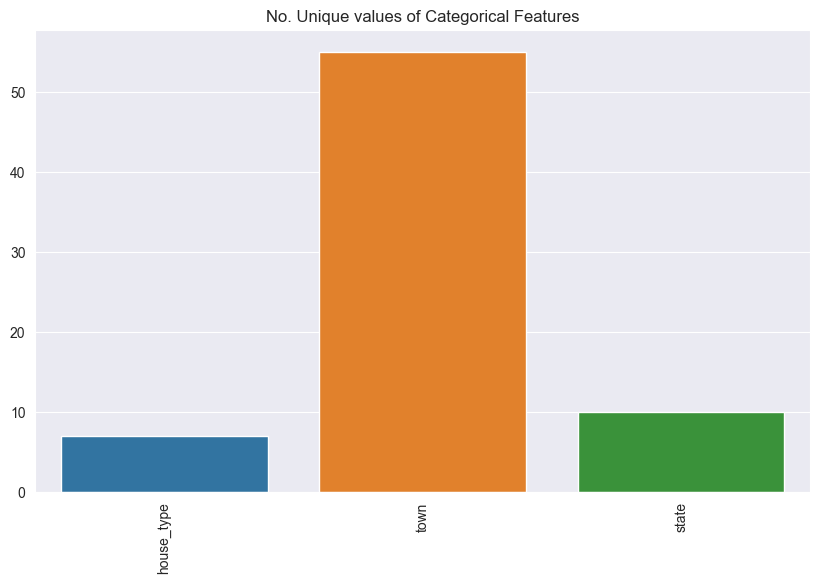

In [176]:
unique_values = []
for col in object_cols:
  unique_values.append(df4[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

C:\Users\ekhat\AppData\Local\Temp\ipykernel_19764\1978742200.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(11, 4, index)


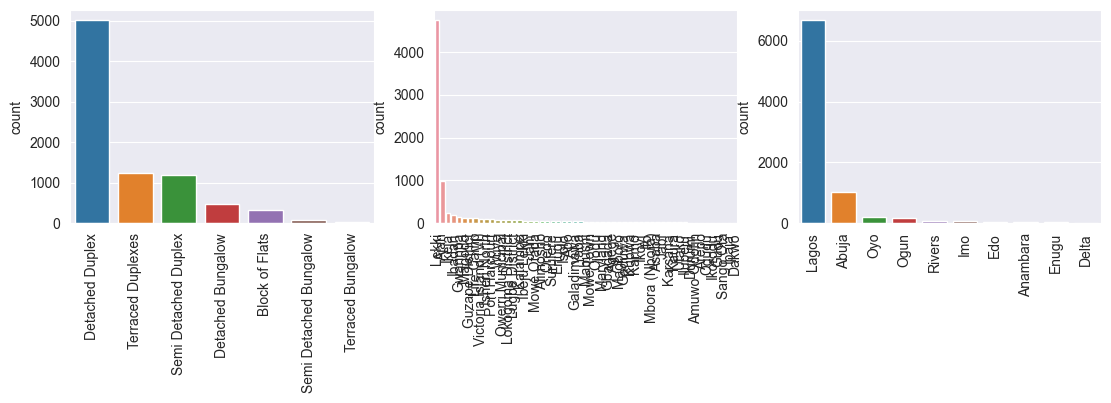

In [177]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1
 
for col in object_cols:
    y = df4[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

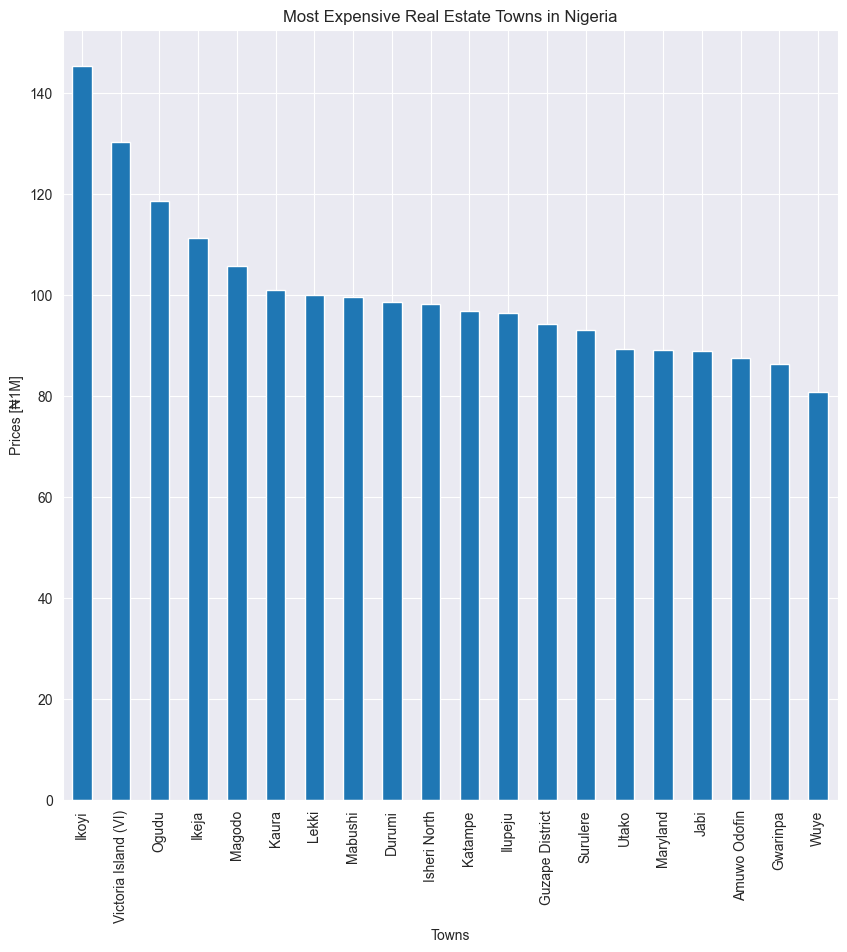

In [178]:
(
    (df4.groupby("town")['price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .head(20)
    .plot(kind="bar",
         xlabel = 'Towns',
         ylabel = "Prices [₦1M]",
         title = "Most Expensive Real Estate Towns in Nigeria")
);



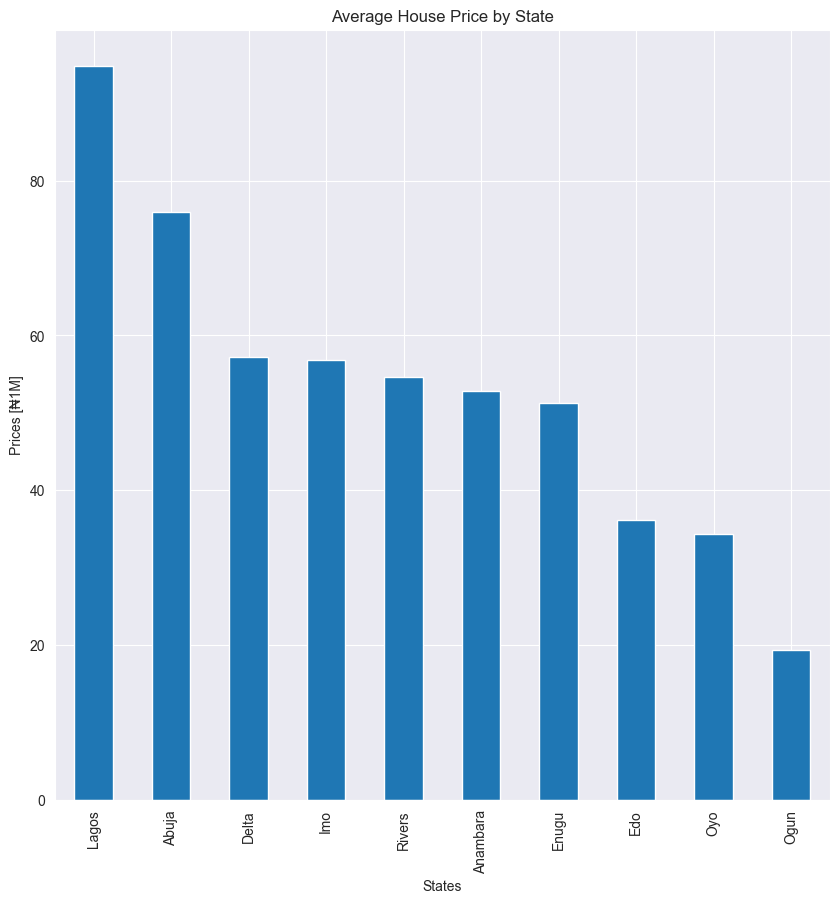

In [179]:
#States with the highest mean prices
(
    (df4.groupby("state")["price"].mean()/1e6)
    .sort_values(ascending=False)
    .plot(kind="bar",
         xlabel = "States", 
         ylabel = "Prices [₦1M]",
          title = "Average House Price by State"
        )
);

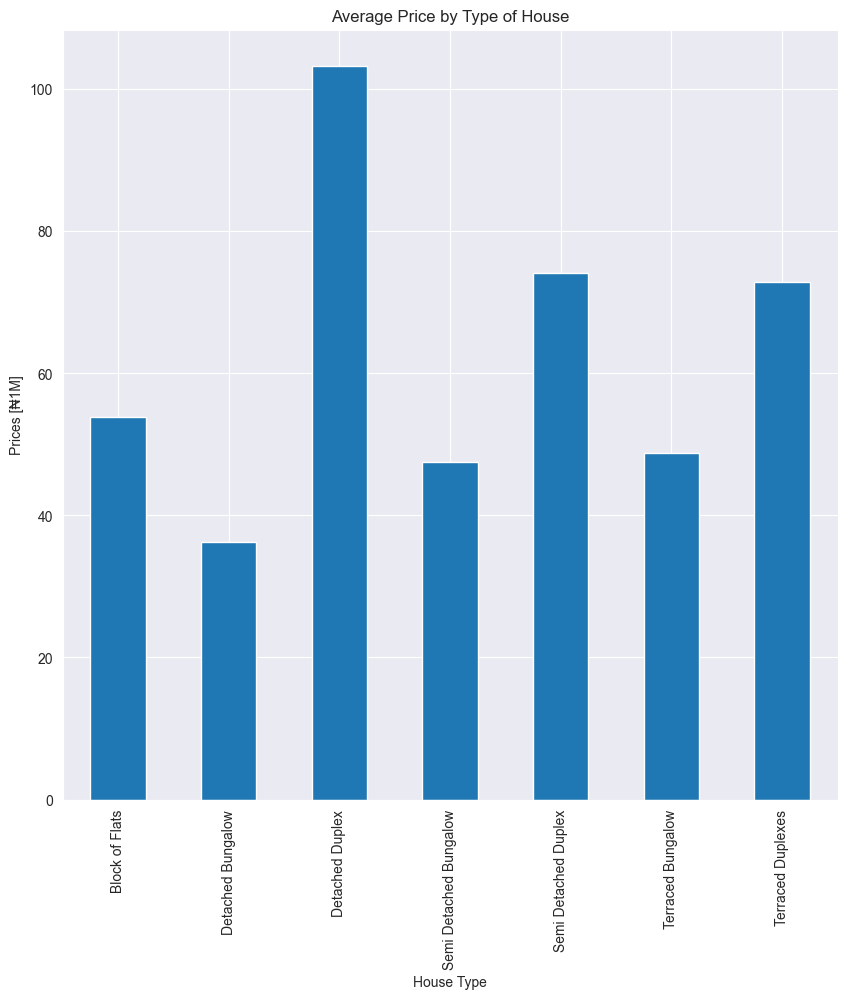

In [180]:
(
    (df4.groupby("house_type")["price"]
     .mean()/1e6)
    .plot(kind="bar",
          xlabel= 'House Type',
          ylabel = "Prices [₦1M]",
          title = "Average Price by Type of House"
         )
);

In [181]:
# corrs = df4.corr()
# corrs # no coreelation for parking space

In [182]:
df4.drop(['parking_space'], axis=1, inplace=True)

C:\Users\ekhat\AppData\Local\Temp\ipykernel_19764\2891321679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.drop(['parking_space'], axis=1, inplace=True)


In [183]:
# corr = df4.corr()
# corr # no coreelation for parking space

In [184]:
# sns.heatmap(corr,cmap ='RdBu',vmin=-1, vmax=1, annot = True)

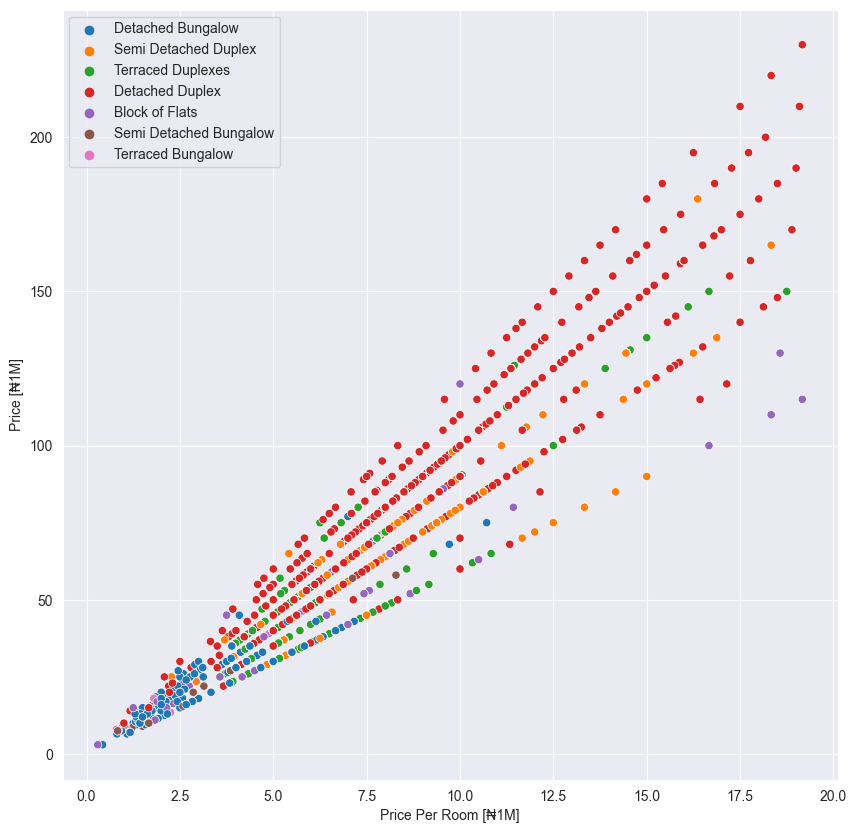

In [185]:
fig,ax = plt.subplots()
plt.xlabel("Price Per Room [₦1M]")
plt.ylabel("Price [₦1M]")
sns.scatterplot(data=df4, hue='house_type', x=df4['price_per_room']/1e6, y=df4['price']/1e6)
plt.legend(loc=2)
plt.show()

In [186]:
df5 =  df4.drop(['price_per_room','total_rooms'], axis=1)
df5.head()


,bedrooms,bathrooms,house_type,town,state,price
3,3.0,3.0,Detached Bungalow,Lokogoma District,Abuja,37000000.0
4,4.0,5.0,Semi Detached Duplex,Gwarinpa,Abuja,75000000.0
5,5.0,5.0,Detached Bungalow,Katampe,Abuja,130000000.0
6,4.0,5.0,Terraced Duplexes,Katampe,Abuja,131000000.0
7,4.0,5.0,Terraced Duplexes,Jahi,Abuja,75000000.0


In [187]:
df5['house_type'].unique()

array(['Detached Bungalow', 'Semi Detached Duplex', 'Terraced Duplexes',
       'Detached Duplex', 'Block of Flats', 'Semi Detached Bungalow',
       'Terraced Bungalow'], dtype=object)

In [188]:
df5['town'].unique()

array(['Lokogoma District', 'Gwarinpa', 'Katampe', 'Jahi',
       'Guzape District', 'Life Camp', 'Gaduwa', 'Utako',
       'Lugbe District', 'Kubwa', 'Galadimawa', 'Durumi', 'Mabushi',
       'Wuye', 'Karmo', 'Mbora (Nbora)', 'Dakwo', 'Jabi', 'Kaura', 'Apo',
       'Gudu', 'Karsana', 'Lekki', 'Ibeju Lekki', 'Port Harcourt',
       'Alimosho', 'Ibadan', 'Ajah', 'Ikorodu', 'Magboro', 'Asaba',
       'Oredo', 'Enugu', 'Owerri Municipal', 'Victoria Island (VI)',
       'Magodo', 'Agege', 'Isheri North', 'Ojodu', 'Ikeja', 'Isolo',
       'Surulere', 'Maryland', 'Gbagada', 'Ikoyi', 'Yaba', 'Ipaja',
       'Amuwo Odofin', 'Ilupeju', 'Ogudu', 'Sango Ota', 'Mowe Ofada',
       'Mowe Town', 'Arepo', 'Ifo'], dtype=object)

In [189]:
df5['state'].unique()


array(['Abuja', 'Anambara', 'Delta', 'Edo', 'Enugu', 'Imo', 'Lagos',
       'Ogun', 'Oyo', 'Rivers'], dtype=object)

In [190]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8347 entries, 3 to 8586
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    8347 non-null   float64
 1   bathrooms   8347 non-null   float64
 2   house_type  8347 non-null   object 
 3   town        8347 non-null   object 
 4   state       8347 non-null   object 
 5   price       8347 non-null   float64
dtypes: float64(3), object(3)
memory usage: 456.5+ KB


In [191]:
df6 = df5.copy()
df6.head()

,bedrooms,bathrooms,house_type,town,state,price
3,3.0,3.0,Detached Bungalow,Lokogoma District,Abuja,37000000.0
4,4.0,5.0,Semi Detached Duplex,Gwarinpa,Abuja,75000000.0
5,5.0,5.0,Detached Bungalow,Katampe,Abuja,130000000.0
6,4.0,5.0,Terraced Duplexes,Katampe,Abuja,131000000.0
7,4.0,5.0,Terraced Duplexes,Jahi,Abuja,75000000.0


# Splitting Dataset into Training and Testing

In [192]:
X = df6.drop(['price'], axis=1)
Y = df6['price']
 
# Split the training set into
# # training and validation set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

# Label Encoder – For Label categorical features

In [193]:
le_house_type = LabelEncoder()
X_train['house_type']= le_house_type.fit_transform(X_train['house_type'])
X_train['house_type'].unique()

array([2, 4, 3, 0, 6, 1, 5])

In [194]:
le_town = LabelEncoder()
X_train['town']= le_town.fit_transform(X_train['town'])
X_train['town'].unique()

array([ 1, 33, 29, 41, 36, 16, 11, 45,  0, 52, 35, 14, 53, 15, 39, 30, 34,
       47, 23, 12, 19, 48, 46, 50, 25, 42,  2, 10, 40, 28,  9, 37, 27, 54,
        5, 51, 24, 17, 38,  4, 26, 21, 20, 31, 43, 44, 18, 22,  3, 32, 49,
        6,  8, 13,  7])

In [195]:
le_state = LabelEncoder()
X_train['state']= le_state.fit_transform(X_train['state'])
X_train['state'].unique()

array([6, 0, 8, 5, 9, 3, 7, 1, 4, 2])

# Transforming test data

In [196]:
X_test['house_type']= le_house_type.transform(X_test['house_type'])
X_test['house_type'].unique()

array([2, 4, 6, 0, 3, 1, 5])

In [197]:
X_test['town']= le_town.transform(X_test['town'])
X_test['town'].unique()

array([33, 34,  1, 47, 15, 16, 29, 25, 36, 17, 19, 48, 14, 39, 30, 43, 31,
       35, 40, 22, 46, 12, 42, 53, 24, 54, 52,  6, 50, 41, 32,  2, 11,  5,
        0, 45, 26,  4, 27, 49, 37, 13, 23,  9,  7,  3, 38, 10, 44, 51, 28,
       21,  8, 18, 20])

In [198]:
X_test['state']= le_state.transform(X_test['state'])
X_test['state'].unique()

array([6, 0, 5, 8, 9, 7, 3, 2, 1, 4])

# Models & Testing for  errors

# Linear Regression Model

In [199]:

from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))


0.40299096040268584


# Decision Tree regression

In [200]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, Y_train)

# predicting a new value
  
# test the output by changing values, like 3750
Y_pred = regressor.predict(X_test)
  
# print the predicted price
print(mean_absolute_percentage_error(Y_test, Y_pred))

0.2639718348059723


# Random Forest Regression Model

In [201]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_test)
print("MAPE:",mean_absolute_percentage_error(Y_test, Y_pred))

MAPE: 0.2641216130306301


# Lasso Regression

In [202]:
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from sklearn.linear_model import Lasso
    # Model training
      
model = Lasso(alpha=0.1)
  
model.fit(X_train, Y_train)
      
# Prediction on test set
  
y_pred = model.predict( X_test )
print(mean_absolute_percentage_error(Y_test, Y_pred))

0.2641216130306301


# Ridge Regression

In [204]:
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from sklearn.linear_model import Ridge
# training model with 0.5 alpha value
model = Ridge(alpha = 0.5, tol = 0.001, \
              solver ='auto', random_state = 42)
model.fit(X_train, Y_train)
# predicting the y_test
y_pred = model.predict(X_test)
print(mean_absolute_percentage_error(Y_test, Y_pred))

0.2641216130306301


# SVM – Support vector Machine Model

In [205]:

from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))

0.5229228445916506


In [206]:
x = np.array([[5,5,'Block of Flats','Katampe','Abuja']])

In [207]:
x[:, 2] = le_house_type.transform(x[:, 2])
x[:, 3] = le_town.transform(x[:, 3])
x[:, 4] = le_state.transform(x[:, 4])
P = x.astype(float)
P

array([[ 5.,  5.,  0., 30.,  0.]])

In [208]:
Y_pred = model_RFR.predict(P)
Y_pred

C:\Users\ekhat\PycharmProjects\pythonProject7777\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([1.258e+08])

# saving the model

In [209]:
import pickle

data = {"model":model_RFR , "le_house_type":le_house_type,"le_town":le_town,"le_state":le_state}
with open('random.pkl', 'wb') as file:
        pickle.dump(data,file)

In [210]:
with open('random.pkl', 'rb') as file:
        data= pickle.load(file)

regression_model = data["model"]
le_house_type = data["le_house_type"]
le_town = data["le_town"]
le_state = data["le_state"]

In [211]:
Y_pred = regression_model .predict(P)
Y_pred

C:\Users\ekhat\PycharmProjects\pythonProject7777\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([1.258e+08])

# END OF CODE